## Matricule & noms : 
`David-Olivier Roy - xxx`

`Amine Melbouci    - xxx` 

`Marc-Antoine Huet - xxx`

<div>
    
# <center> ELE8812 - Traitement et analyse d'images </center>
## <center> Travail pratique No. 3 </center>
### <center> Restauration d'images & Segmentation d’images et détection de contours</center>
<center>Hiver 2021 </center>

<div>

Ce laboratoire est séparé en deux parties:
* **Partie 1**: Restauration d'image (10 pts)
* **Partie 2**: Segmentation d'image et détection de contours (10 pts)

**Date de remise**
- Groupe 1: 21 mars 23h59  
- Groupe 2: 28 mars 23h59  

## Partie 1: Restauration d'images

Ce travail pratique a pour objet la mise en œuvre et la comparaison de quelques techniques
de restauration d’images opérant soit dans le domaine spatial, soit dans le domaine
fréquentiel.


Les  données à utiliser pour effectuer ce travail pratique se trouvent dans l’archive <I>TP3.zip</I> disponible sur le site web du cours.    
   

<b>Total : 20 points</b> 

<div class="alert alert-block alert-info">


La cellule ci-dessous effectue des <code>import</code> cela s'assimile a un<code>addpath</code> en matlab. Le but est d'amener des fonctions extérieures (packages) dans le notebook afin que Python les reconnaisse.  
<code> import package as pkg</code> permet de raccourcir le nom de ce dernier. Les fonctions contenues dans 'package' seront alors appelées ainsi <code>pkg.function()</code><br>
    
Vous pouvez chercher sur google chacun des package appelés ci-dessous afin d'obtenir leur documentation.<br>

N'oubliez pas de relancer cette cellule si jamais vous redemarrez le Kernel !!
</div>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread
import cv2
import numpy as np
from scipy.ndimage import convolve
import skimage.filters as skfilters
import skimage.morphology as skmorph

import sys
from matplotlib.path import Path
from scipy.ndimage import sobel, gaussian_filter, gaussian_laplace
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage import draw
from skimage.morphology import convex_hull_image
from skimage.draw import line

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 10)
# install scikit image et scipy
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install scikit-image

##  1.1 Dégradation de type « flou cinétique » (3 pts)

On s’intéresse ici à une image affectée par une dégradation de type « flou cinétique ». Ce
type de dégradation se produit lorsque le système de prise d’image se déplace pendant qu’il
est en train de capter la scène, ou lorsque l’objet imagé bouge durant l’acquisition. Si l’on
considère un déplacement de direction et de vitesse constante paramétré par (𝑎, 𝑏), où 𝑎 et
𝑏 désignent les coordonnées du vecteur de déplacement total en proportion de la taille des
axes de l’image 𝑋 et 𝑌, alors la réponse fréquentielle de la dégradation peut s’écrire:

\begin{equation}
H(u,v)= \frac{sin(\pi(ua + vb)}{\pi(ua + vb)}e^{-i\pi(ua + vb)} = sinc(\pi(ua + vb)e^{-i\pi(ua + vb)}.
\end{equation}



<div class="alert alert-block alert-warning">
D'abord, chargez l’image <i>chelsea_the_cat.tif</i> et normalisez l'image entre les valeurs 0 et 1.
    </div>

Text(0.5, 1.0, 'Image normalisée entre 0 et 1')

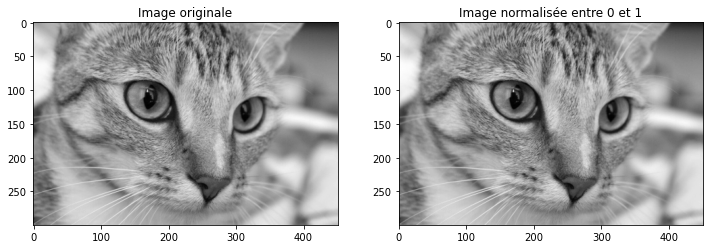

In [6]:
# Inscrivez votre code ici
img=plt.imread('chelsea_the_cat.tif')
plt.subplot(1,2,1)#Image originale
plt.imshow(img, cmap='gray')
plt.title('Image originale')
img_norm =img/np.max(img)
plt.subplot(1,2,2)#Image originale
plt.imshow(img_norm, cmap='gray')
plt.title('Image normalisée entre 0 et 1')


<div class="alert alert-block alert-warning">
Appliquez une dégradation de type flou cinétique d’abord dans le domaine spatial en
utilisant 𝑘(𝑥, 𝑦), puis dans le domaine fréquentiel en utilisant 𝐻(𝑢, 𝑣). Comparez
les résultats.
    </div>

Le code ci-dessous définit la réponse fréquentielle H(u,v) de la dégradation de type flou cinétique ainsi que h(x,y) pour une vitesse de déplacement 
𝑎 = 𝑏 = 0.05, et pour une image de taille 300 x 451.

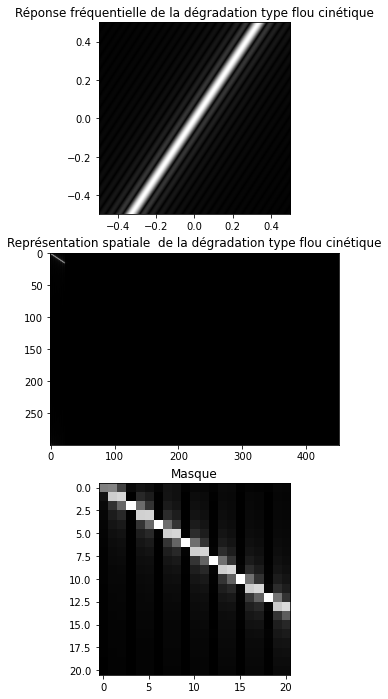

In [8]:
# Définition des paramètres
a = 0.05
b = 0.05
n = 300
m = 451

# u et v vont de -n/2 à n/2 et -m/2 à m/2 respectivement
u, v = np.mgrid[1:n + 1, 1:m + 1]
u = u - np.ceil((n + 1) / 2)
v = v - np.ceil((m + 1) / 2)

# Réponse fréquentielle
H = np.sinc(u*a+b*v)*np.exp(np.array([-1j])*np.pi*(u*a+b*v))

# Conversion de la réponse fréquentielle dans le domaine spatial
h = np.fft.ifft2(np.fft.ifftshift(H))

# Masque de dégradation style bougé k(x, y) dans le domaine spatiale
# La taille du masque influencera la dégradation de l'image
k = h[0:21,0:21] 

fig, ax  = plt.subplots(3, figsize=(12,12))
ax[0].imshow(abs(H), cmap='gray', extent=[-0.5, 0.5, -0.5, 0.5])
ax[0].title.set_text('Réponse fréquentielle de la dégradation type flou cinétique')
ax[1].imshow(abs(h), cmap='gray')
ax[1].title.set_text('Représentation spatiale  de la dégradation type flou cinétique')
ax[2].imshow(abs(k), cmap='gray')
ax[2].title.set_text('Masque')

Text(0.5, 1.0, 'Image dégradée domaine spatial')

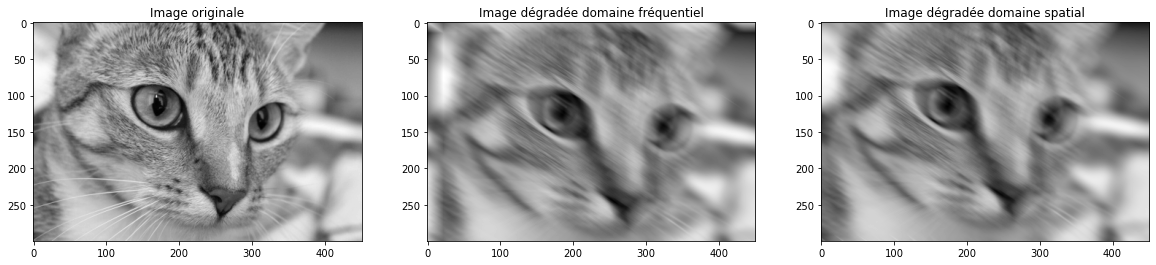

In [9]:
plt.figure(num=None,facecolor='white', figsize=(20,20))
plt.subplot(1,3,1)#Image originale
plt.imshow(img, cmap='gray')
plt.title('Image originale')
# Application de la dégradation et retour au domaine fréquentiel
imgFreq = np.fft.fftshift(np.fft.fft2(img_norm))
degradFreq = imgFreq*H
imgdegradFreqFFT = np.fft.ifft2(np.fft.fftshift(degradFreq))
plt.subplot(1,3,2)#Domaine fréquentiel
plt.imshow(abs(imgdegradFreqFFT), cmap='gray')
plt.title('Image dégradée domaine fréquentiel')
# Application de la dégradation et retour au domaine spatial
img_spatial= convolve(img_norm, k)
plt.subplot(1,3,3)#Domaine spatial
plt.imshow(abs(img_spatial), cmap='gray')
plt.title('Image dégradée domaine spatial')

<div class="alert alert-block alert-success"> 
    En tentant d'analyser les différents résultats à travers les résultats obtenus, il est difficile de déterminer les différences et ressemblances hormis le fait que l'image dégradée dans le domaine spatial offre une meilleure illusion d'optique de mouvement. La dégradation est en effet moins uniforme que pour la dégradation en domaine fréquentiel, ce qui explique cet effet. La limitation du masque ainsi que la convolution de l'image donne ce résultat.
</div>

## 1.2 Bruitage des images (1 pt)
<div class="alert alert-block alert-warning">
Sélectionnez une des images dégradées et ajoutez un bruit gaussien de variance égale à 0.001 et de moyenne nulle.
    </div>

Text(0.5, 1.0, 'Image bruit gaussien dans domaine frequentiel')

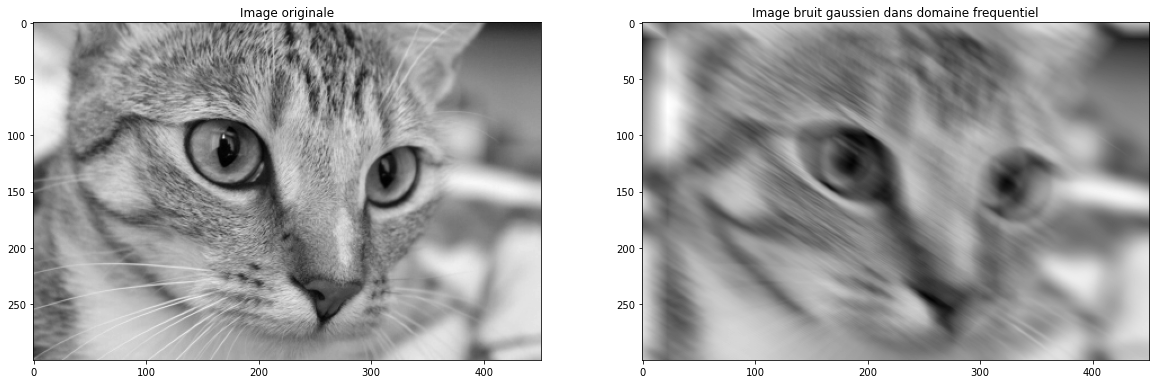

In [14]:
#Bruit gaussien (utiliser np.random.normal())
bruit_gausse= np.random.normal(0, 0.001, imgdegradFreqFFT.shape)
img_freq_bruit_gaussien= abs(imgdegradFreqFFT)+bruit_gausse
plt.figure(num=None,facecolor='white', figsize=(20,20))
plt.subplot(1,2,1)#Image dégradée domaine spatial
plt.imshow(img, cmap='gray')
plt.title('Image originale')
plt.subplot(1,2,2)#Image dégradée domaine spatial avec bruit gaussien
plt.imshow(img_freq_bruit_gaussien, cmap='gray')
plt.title('Image bruit gaussien dans domaine frequentiel')

<div class="alert alert-block alert-warning">
Ajoutez ensuite à cette image bruitée du bruit de type « Sel & Poivre ». Vous pouvez utiliser la fonction ci-dessous pour rajouter le bruit.

Cette image sera le point de départ des traitements de la section suivante.
    </div>
    

In [26]:
def sel_et_poivre(img, noise_factor=101):
    """ Ajoute du bruit poivre et sel à une image img
    
    img (ndarray): Image d'entrée
    noise_factor (int): 2/noise_factor des pixels seront poivre ou sel en moyenne. Plus le noise_factor diminue, 
                        plus de pixels seront affectés.
    """
    # Génération aléatoire de données entre 0 et noise_factor - 1 avec une taille similaire à img
    noise = np.random.randint(noise_factor, size=img.shape)
    img = np.where(noise == 0, 0, img)
    img = np.where(noise == (noise_factor - 1), 1, img)
    return img

Text(0.5, 1.0, 'Image dégradée avec bruit gaussien et bruit sel et poivre')

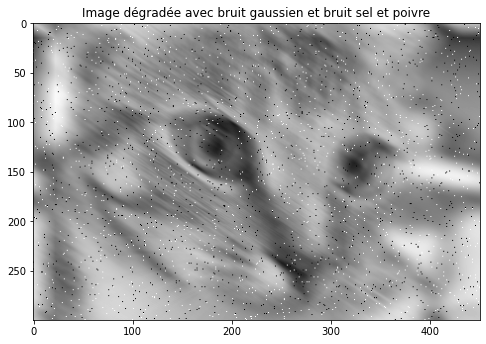

In [31]:
img_sel_et_poivre = sel_et_poivre(img_freq_bruit_gaussien, noise_factor=101)
plt.figure(figsize=(8,8))
plt.imshow(img_sel_et_poivre, cmap='gray')
plt.title('Image dégradée avec bruit gaussien et bruit sel et poivre')

## 1.3 Restauration dans le domaine fréquentiel (3 pts)
### Restauration par filtrage de Wiener
<div class="alert alert-block alert-warning">
On fait l’hypothèse que l’image à restaurer et le bruit sont des processus gaussiens blancs
de moyenne nulle. Le filtre de Wiener prend alors la forme de l’expression suivante:
    
\begin{equation}
W(u,v) = \frac{H^*(u,v)}{ \mid H(u,v) \mid ^ 2 + \lambda}
\end{equation}

Où H représente la réponse fréquentielle de la dégradation appliquée à l'image et * représente le conjugué.  
L'image restaurée $\hat{F}(u,v)$ prend donc la forme:
    
\begin{equation}
\hat{F}(u,v) = \frac{H^*(u,v)}{ \mid H(u,v) \mid ^ 2 + \lambda}G(u,v)
\end{equation}
    
Où G est la réponse fréquentielle de l'image dégradée.

Mettez en œuvre ce filtre pour une valeur nulle de λ. Déterminez ensuite une valeur de λ fournissant un compromis
acceptable.
    </div>

In [32]:
# Inscrivez votre code ici
def Wiener_filter(R_H, lambda_):
    """ Application du filtre Wiener sur image 
    
    R_H: la réponse fréquentielle de la dégradation appliquée à l'image.
    lambda: 
    """
    # Génération aléatoire de données entre 0 et noise_factor - 1 avec une taille similaire à img
    F_H= np.conjugate(R_H)/((abs(R_H)**2)+ lambda_)
    return F_H

Text(0.5, 1.0, 'Lambda= 1')

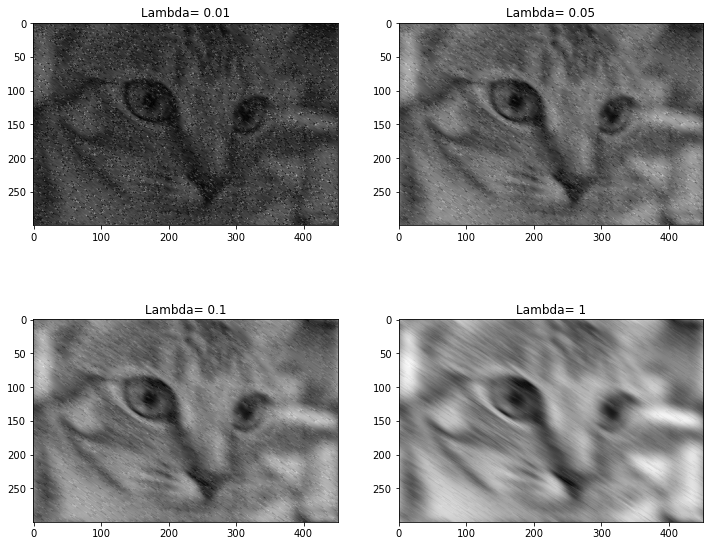

In [33]:
#Transformer l'image dans le domaine fréquentiel
G = np.fft.fftshift(np.fft.fft2(img_sel_et_poivre))

#Impression Image avec Lambda= 0.01
a = Wiener_filter(H, 0.01)*G
b = np.fft.ifft2(np.fft.ifftshift(a))
plt.subplot(2,2,1)
plt.imshow(abs(b), cmap='gray')
plt.title('Lambda= 0.01')
#Impression Image avec Lambda= 0.05
a_1 = Wiener_filter(H, 0.05)*G
b_1 = np.fft.ifft2(np.fft.ifftshift(a_1))
plt.subplot(2,2,2)
plt.imshow(abs(b_1), cmap='gray')
plt.title('Lambda= 0.05')
#Impression Image avec Lambda= 0.1
a_2 = Wiener_filter(H, 0.1)*G
b_2 = np.fft.ifft2(np.fft.ifftshift(a_2))
plt.subplot(2,2,3)
plt.imshow(abs(b_2), cmap='gray')
plt.title('Lambda= 0.1')
#Impression Image avec Lambda= 1
a_3 = Wiener_filter(H, 1)*G
b_3 = np.fft.ifft2(np.fft.ifftshift(a_3))
plt.subplot(2,2,4)
plt.imshow(abs(b_3), cmap='gray')
plt.title('Lambda= 1')

<div class="alert alert-block alert-warning">
Expliquez le résultat obtenu. 
    </div>

<div class="alert alert-block alert-success"> 
En procédant par essaie-erreur, on obtient une valeur de lambda d'environ 0.05. Le résultat obtenu nous permet d'affirmer qu'une très grande partie du mouvement 'flou cinétique' a été éliminée avec le filtre de Wiener. Toutefois, l'image demeure excessivement bruitée. Par définition le filtre de Wiener, comme mentionné plus haut, repose excessivement sur l'utilisation de gains. Le filtre sel et poivre peut être considéré comme des fréquences parasytes à hauts niveaux. Cela explique le bruit persistant dans toute l'image, en effet ces fréquences ont étées étirées tout au long de l'image
</div>

<div class="alert alert-block alert-warning">
Donnez une interprétation à λ.
</div>

<div class="alert alert-block alert-success"> 
En comparant les résultats du filtre de Wiener du lambda approprié avec d'autres valeurs de lambda aléatoire on constate que lambda agit comme un filtre passe-bas pour le flou cinétique. En effet plus le lambda est élevé, plus l'illusion de mouvement est grande. 
</div>

## 1.4 Restauration dans le domaine spatial (3 pts)
Pour réduire l’effet du bruit sur la restauration d’image, on peut appliquer un filtre spatial
avant d’utiliser le filtre de Wiener. 

<div class="alert alert-block alert-warning">
Appliquez un filtre médian de taille 3x3 à l’image bruitée. Pour la création de filtres vous pouvez utiliser le module <a href="https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.median"> skimage</a>.
    </div>

Text(0.5, 1.0, 'Filtrage médian')

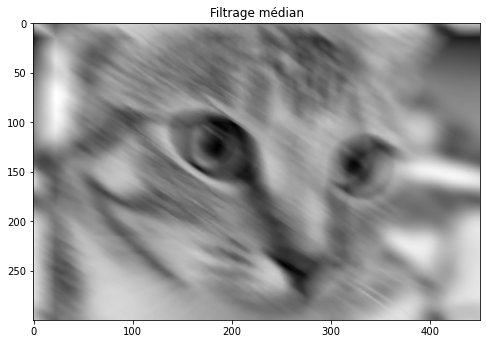

In [35]:
filtre_median = skfilters.median(img_sel_et_poivre) # Par défaut c'est 3x3 quand on ne met rien.
plt.figure(figsize=(8,8))
plt.imshow(filtre_median, cmap="gray")
plt.title("Filtrage médian")


<div class="alert alert-block alert-warning">
Utilisez ensuite le filtre de Wiener pour inverser la dégradation cinétique et comparez les images restaurées lorsque le filtre médian est appliqué avant le filtre Wiener et lorsque le filtre médian n'est pas appliqué.
<p style="color:red"><b>Remarque:</b> Utilisez la valeur optimale de $\lambda$  trouvée à la question 2.</p>
    </div>

Text(0.5, 1.0, 'Filtrage Wiener sans filtrage médian')

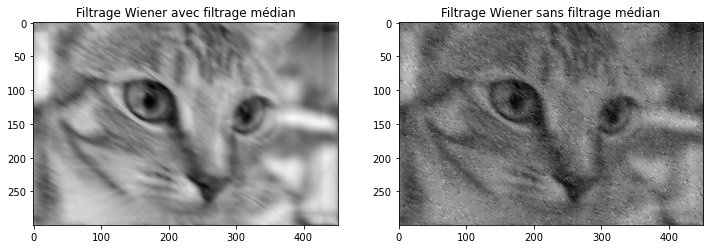

In [42]:
#Application filtre médian+ Wiener 
img_median_wiener_F=np.fft.fftshift(np.fft.fft2(filtre_median))
img_median_wiener = Wiener_filter(H, 0.05)*img_median_wiener_F
img_median_wiener_ = np.abs(np.fft.ifft2(np.fft.ifftshift(img_median_wiener)))
plt.subplot(1,2,1)
plt.imshow(img_median_wiener_, cmap="gray")
plt.title("Filtrage Wiener avec filtrage médian")
#Application filtre Wiener 
a_4 = Wiener_filter(H, 0.05)*G
b_4 = np.fft.ifft2(np.fft.ifftshift(a_4))
plt.subplot(1,2,2)
plt.imshow(np.abs(b_4), cmap="gray")
plt.title("Filtrage Wiener sans filtrage médian")



<div class="alert alert-block alert-warning">
Qu'est-ce qui est corrigé par le filtre médian ?
    </div>

<div class="alert alert-block alert-success"> 
Le filtre médian a permis de corriger le bruit causé par le filtre sel et poivre. Par définition, le filtre médian en effectuant la moyenne des pixels avoisinnants, les fréquences parasytes des pixels blancs et noires, l'affectent peu. Cela permet dans un premier temps de bien filtrer les effets du filtre sel et poivre. Ensuite, le flou cinétique est filtré grâce au filtre de Wiener.
</div>

## Partie 2: Segmentation d’images et détection de contours
    
Les photo-radars sont de plus en plus populaires sur les autoroutes québécoises. L’objectif de  ce  travail  pratique  est  d’approfondir  plusieurs  techniques  de  segmentation  d’images vues en cours. Il est question de segmenter une image d’un véhicule en déplacement afin 
d’extraire  la  région  contenant  la  plaque  d’immatriculation.


<b>Pondération</b> 
   - SEGMENTATION D'UNE PLAQUE D'IMMATRICULATION (10 PTS)
   
<b>Total : 10 points</b>


    
    
##  2. DÉTECTION D’UNE PLAQUE D’IMMATRICULATION (10 pts)

La **figure 1** présente l'image d’un véhicule prise à un temps t. À partir de cette image, il vous est demandé d’en segmenter la plaque d’immatriculation tel que montré dans la **figure 2**. <br/><br/>

| <center> Figure 1: Voiture au temps t </center> |
|------|
|   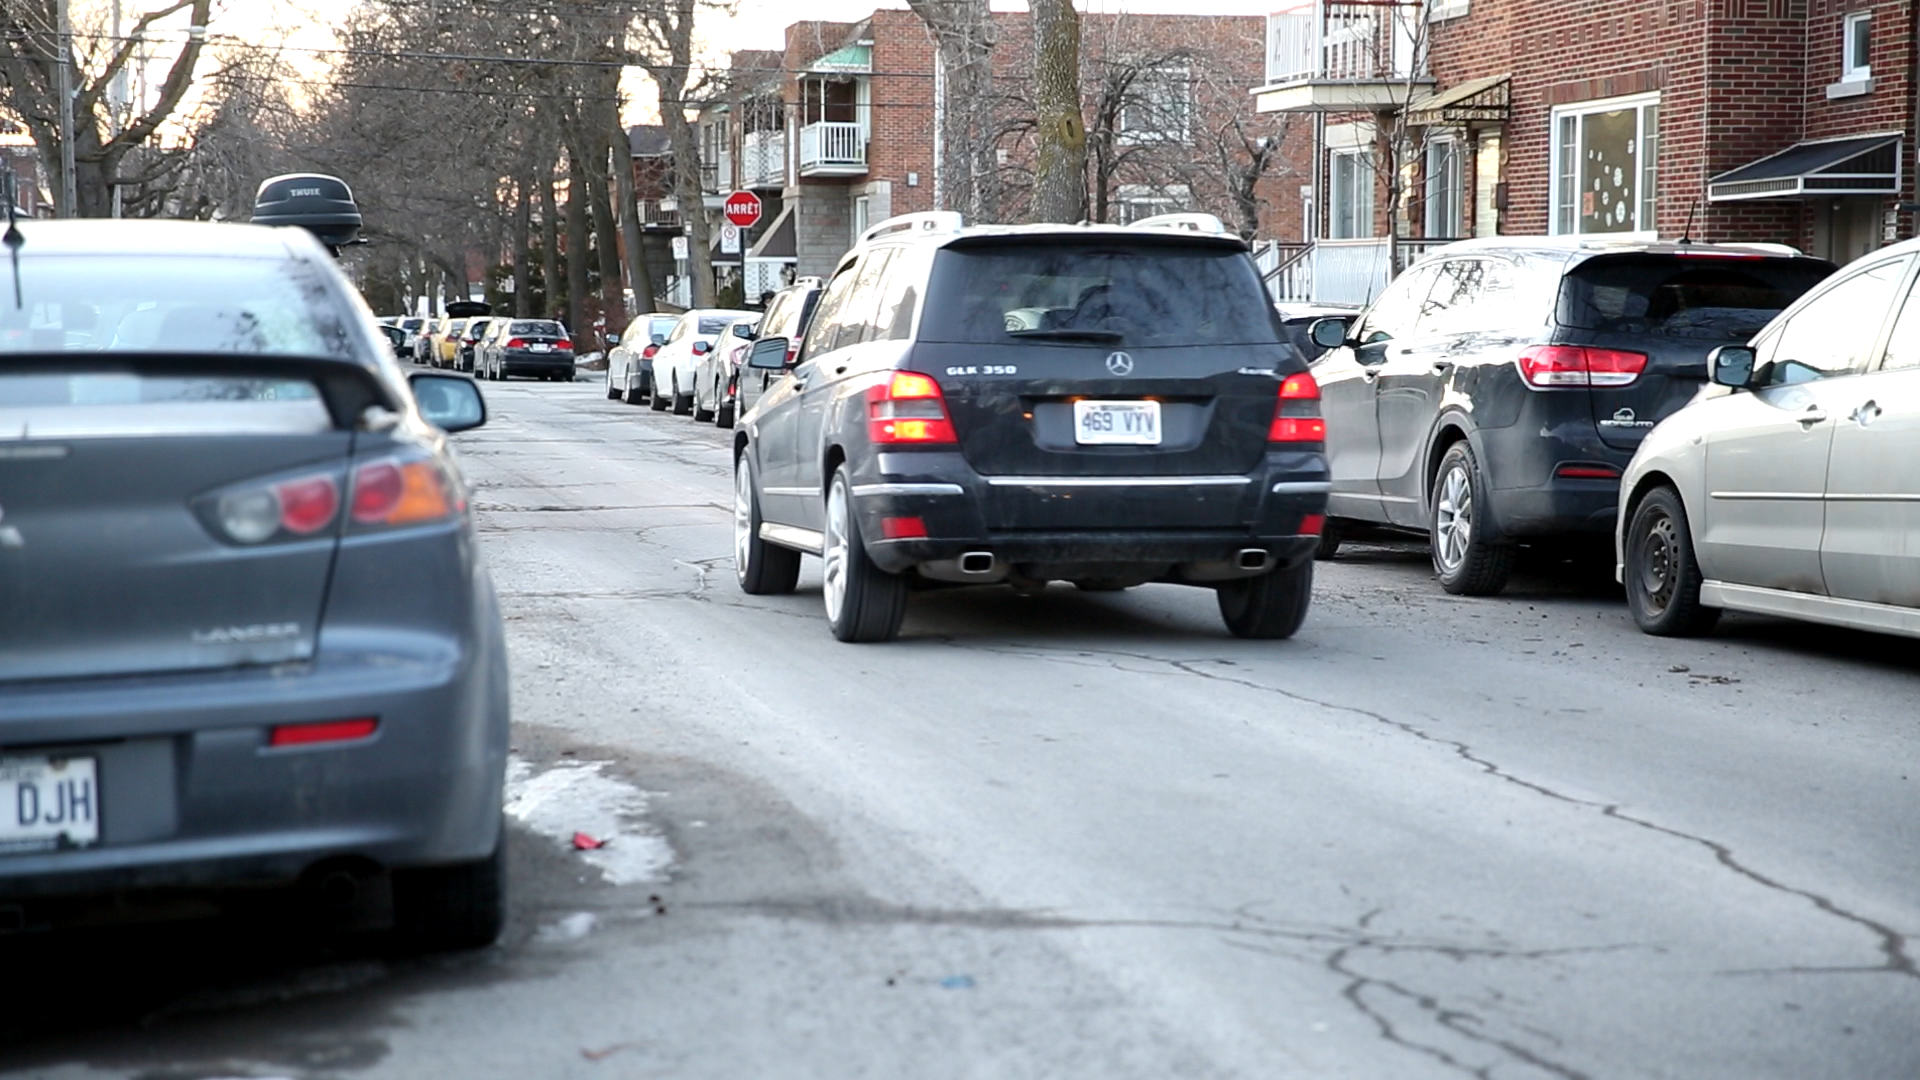  |
    
    
| <center> Figure 2: Plaque d'immatriculation </center> |
|------|
| 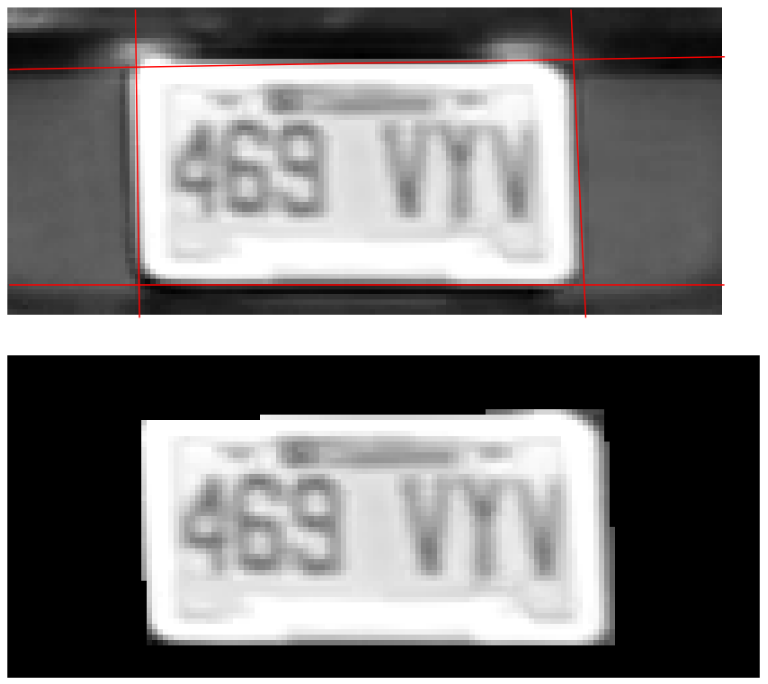 |


## 2.1 Détection de contours (3 pts) 

Le but de cette étape est d’obtenir le contour de la plaque d’immatriculation. On demande 
de détecter les contours avec les trois méthodes vues en classe : gradient de l’image, Marr-
Hildreth (log) et Canny. Ces méthodes seront mises en œuvre à l’aide de la fonction [*sobel* de Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html) pour la méthode du gradient, la fonction marr_hildreth définie dans ce travail et la fonction [*canny* de scikit-image](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.canny).


### 2.1.1 Méthode du Gradient (1 pt) 
<div class="alert alert-block alert-warning">
Utilisez  les  composantes  du  gradient  en x  et  en y obtenu grâce à la fonction *sobel*.

- Expliquez brièvement la méthode du gradient

- Observez et discutez de l’effet de la valeur du seuil  

- Observez et discutez d’un filtrage passe-bas préalable à la détection des contours (e.g. un filtre gaussien)  de l’effet de la valeur du seuil
</div>

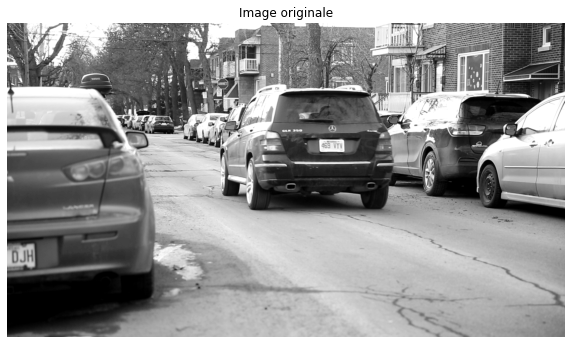

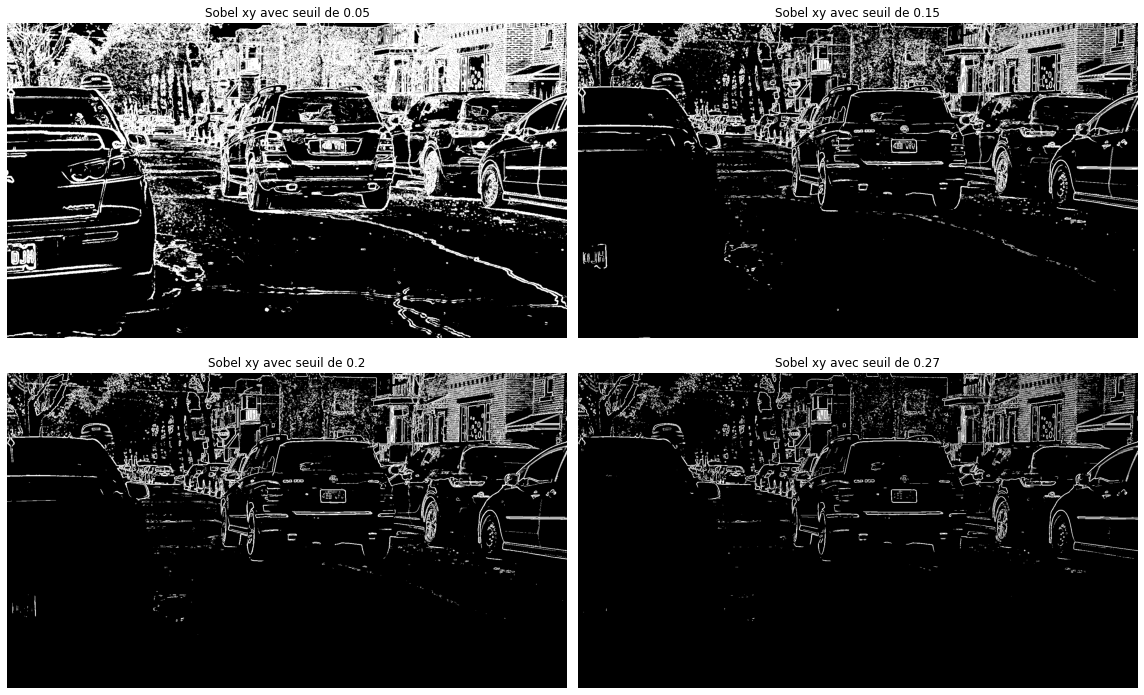

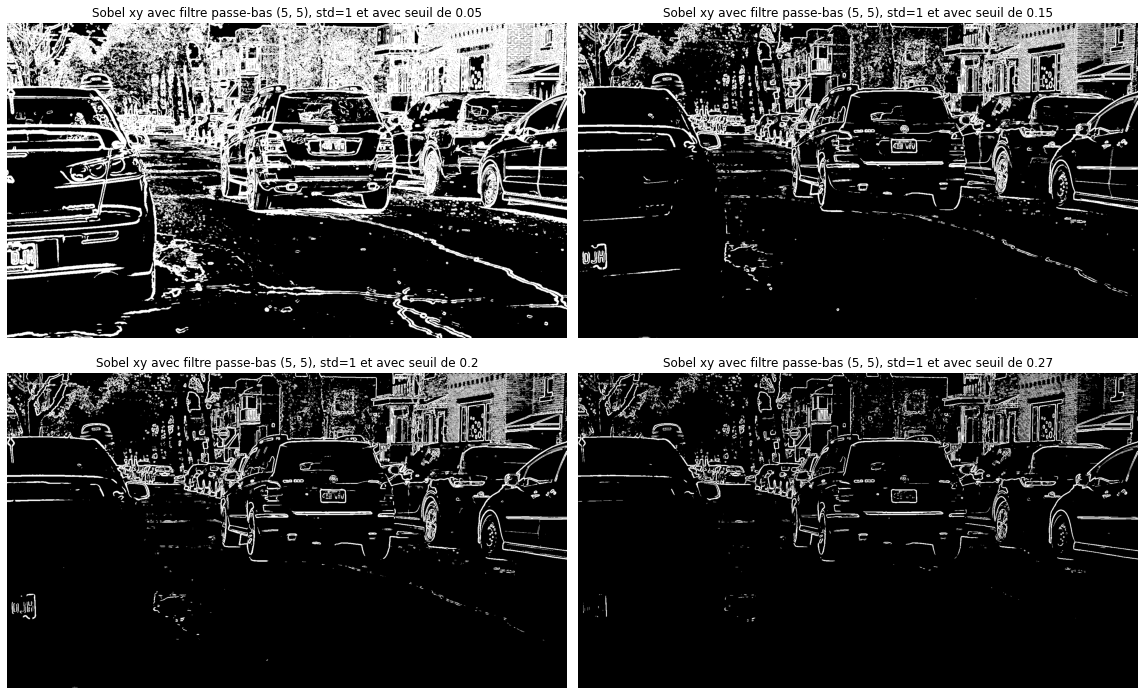

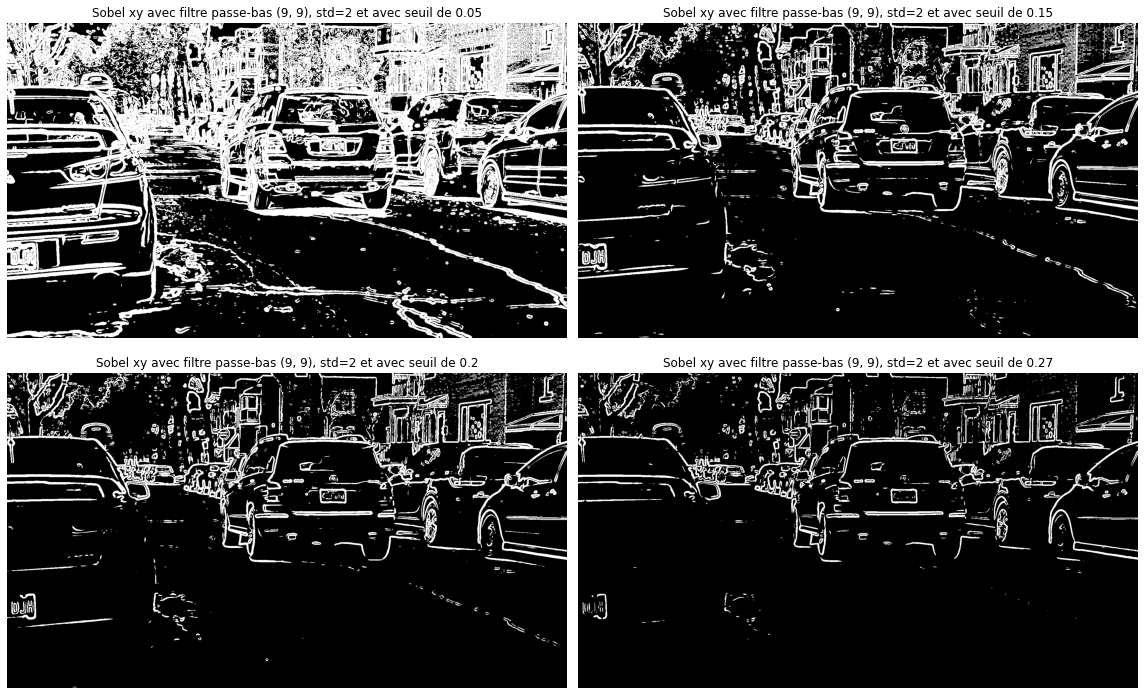

In [37]:
# Toutes les valeurs de l'image au-dessus du seuil sont associées à une intensité
# de 1. Les valeurs en-dessous sont associées à 0. L'image est d'abord renormalisée.
def seuil_fct(image, seuil):
    image = (image-image.min())/image.max()
    image_out = np.zeros(image.shape)
    image_out[image>=seuil] = 1
    return image_out

# Seuils
seuils = [0.05, 0.15, 0.2, 0.27]

# Image originale
image = cv2.imread("voiture_t.png", cv2.IMREAD_GRAYSCALE) / 255.0
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.imshow(image, cmap="gray")
ax.set_title("Image originale")
ax.axis("off")

# Sobel
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs = axs.reshape(4)
for i, ax in enumerate(axs):
    image_sobel = skfilters.sobel(image)
    ax.imshow(seuil_fct(image_sobel, seuils[i]), cmap="gray")
    ax.set_title(f"Sobel xy avec seuil de {seuils[i]}")
    ax.axis("off")
plt.tight_layout()
              
# Sobel avec filtrage gaussien 1
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs = axs.reshape(4)
filter_size = (5,5)
std = 1
for i, ax in enumerate(axs):
    image_sobel_gauss = skfilters.sobel(cv2.GaussianBlur(image,filter_size, std))
    ax.imshow(seuil_fct(image_sobel_gauss, seuils[i]), cmap="gray")
    ax.set_title(f"Sobel xy avec filtre passe-bas {filter_size}, std={std} et avec seuil de {seuils[i]}")
    ax.axis("off")
plt.tight_layout()

# Sobel avec filtrage gaussien 2
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs = axs.reshape(4)
filter_size = (9,9)
std = 2
for i, ax in enumerate(axs):
    image_sobel_gauss = skfilters.sobel(cv2.GaussianBlur(image,filter_size, std))
    ax.imshow(seuil_fct(image_sobel_gauss, seuils[i]), cmap="gray")
    ax.set_title(f"Sobel xy avec filtre passe-bas {filter_size}, std={std} et avec seuil de {seuils[i]}")
    ax.axis("off")
plt.tight_layout()

<div class="alert alert-block alert-success"> 
Méthode du gradient :
En chaque point de l'image, on calcule le gradient selon x ou y à l'aide d'une approximation numérique. Ici, on fait une convolution d'un filtre Sobel 3x3 qui calcule le gradient à l'aide de 9 points. Le gradient est calculé en x et en y et on calcule ensuite la norme L2 des gradients. On a alors directement les contours.
Valeur du seuil :
Le seuil permet de ne sélectionner que les valeurs de gradient que l'on considère comme étant des contours d'intérêt (c.-à-d. des contours suffisamment abrupts). On voit que si la valeur de seuil est trop faible, l'image de contours est surchargée. De même, si la valeur est trop haute, on perd certains contours moins prononcés.
Application d'un filtre passe-bas:
Le filtre passe-bas a pour effet d'adoucir les contours. Cela élimine les variations de contour à haute fréquence et rend les contours plus larges, d'où la nécessité de choisir des valeurs de seuil et de taille de filtre appropriées. L'élargissement des contours sera annulé si on choisit une valeur de seuil suffisamment élevée.
</div>

### 2.1.2 Méthode de Marr-Hildreth (1 pt) 

<div class="alert alert-block alert-warning">
La méthode Marr-Hildreth peut être calculée grâce à la *marr_hildreth* définie ci-dessous.

- Expliquez brièvement la méthode de Marr-Hildreth </div>

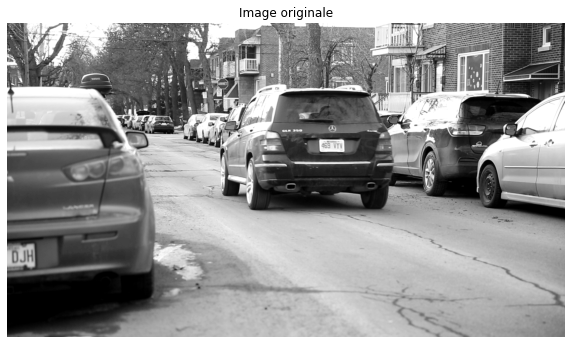

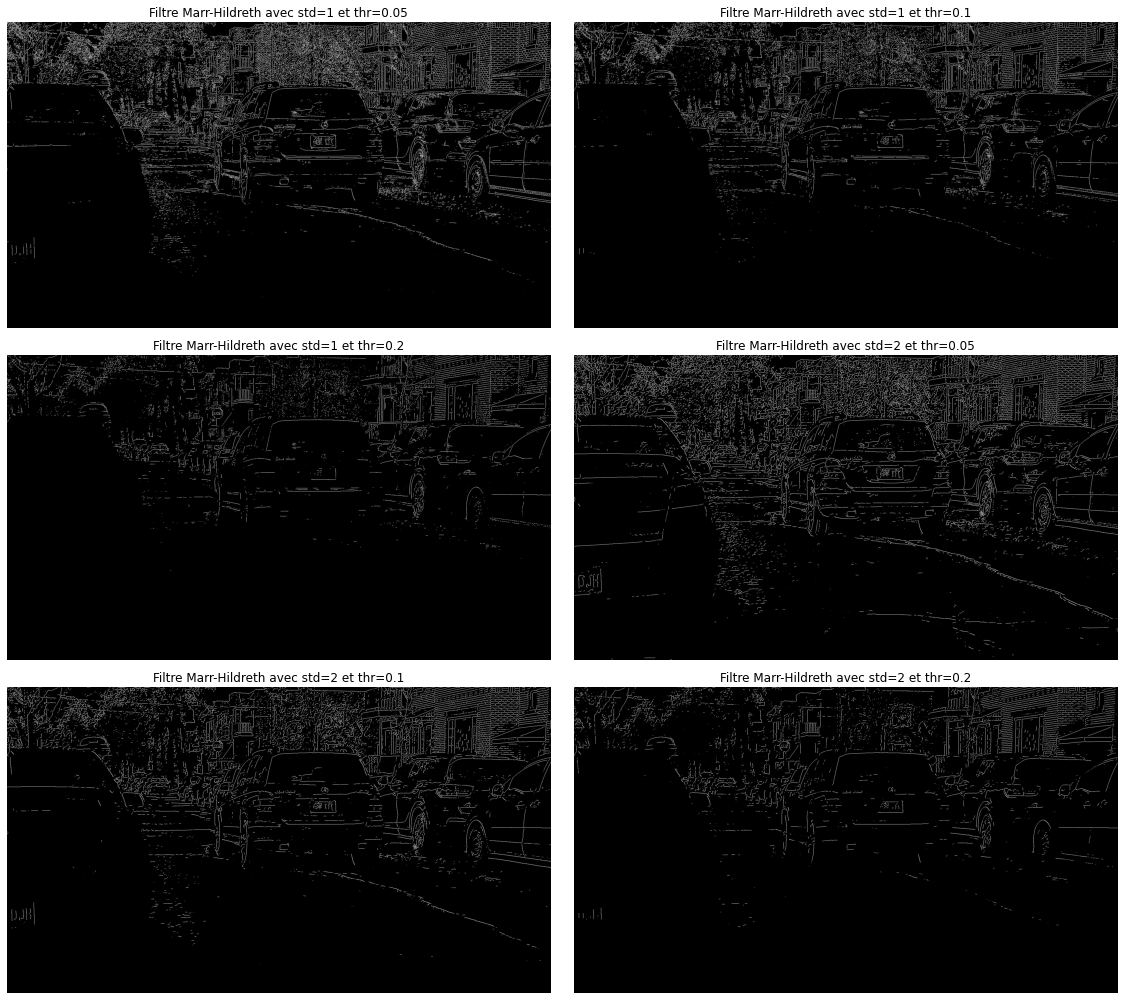

In [38]:
def marr_hildreth(img, sigma=1, thr=0.1):
    """Détection de contours avec la méthode Marr-Hildreth
    
    img (ndarray): Image d'entrée.
    sigma (float): Écart-type de la gaussienne.
    thr (float): Seuil de détection de contours (valeur attendue entre 0 et 1).
    """
    # Application de LoG
    log = gaussian_laplace(img, sigma=sigma)
    
    edges_log = np.zeros(log.shape)
    edges_thr = np.zeros(log.shape)
    
    # Trouver les passage par zero
    edges_log[np.where(np.diff(np.sign(log), axis=0))] = 1
    edges_log[np.where(np.diff(np.sign(log), axis=1))] = 1
    
    # Trouver les différences de gradient les plus importantes
    norm_thr = np.diff(log).max() * thr
    edges_thr[np.where(np.diff(log, axis=0) > norm_thr)] = 1
    edges_thr[np.where(np.diff(log, axis=1) > norm_thr)] = 1
    
    return edges_log * edges_thr

# Image originale
image = cv2.imread("voiture_t.png", cv2.IMREAD_GRAYSCALE) / 255.0
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.imshow(image, cmap="gray")
ax.set_title("Image originale")
ax.axis("off")

param = [{"std":1, "thr":0.05}, {"std":1, "thr":0.1}, {"std":1, "thr":0.2}, 
         {"std":2, "thr":0.05}, {"std":2, "thr":0.1}, {"std":2, "thr":0.2}]
fig, axs = plt.subplots(3,2, figsize=(16,14))
axs = axs.reshape(6)
for i, ax in enumerate(axs):
    std = param[i]["std"]
    thr = param[i]["thr"]
    image_marr_hildreth = marr_hildreth(image, std, thr)
    ax.set_title(f"Filtre Marr-Hildreth avec std={std} et thr={thr}")
    ax.imshow(image_marr_hildreth, cmap="gray")
    ax.axis("off")
plt.tight_layout()

<div class="alert alert-block alert-success"> 
Dans la méthode de Marr-Hildreth, on utilise le laplacien plutôt que le gradient (convolution d'un filtre 3x3). Puisque le laplacien utilise des dérivées secondes, on obtient 2 pics aux alentours d'un contour (le gradient change de signe). On doit trouver le passage par 0 entre les 2 pics, qui correspond au centre du contour. À cause de la forte sensibilité au bruit, on applique d'abord un filtre gaussien.
</div>

### 2.1.3 Méthode de Canny (1 pt) 

<div class="alert alert-block alert-warning">
La méthode de Canny peut être calculée grâce à la fonction *canny*.

- Expliquez brièvement la méthode de Canny 

Pour la suite du TP, utilisez la segmentation de contour obtenue par Canny. Vous devriez obtenir une image semblable à celle de la **figure 3**. Afin de réduire la charge de travail du TP, vous devez cadrer manuellement la segmentation du contour de la plaque. Pour l'extraction manuelle, vous pouvez grossièrement sélectionner les coordonnées de l'image cadrant la plaque d'immatriculation. La **figure 4** montre ce cadrage.
    
| <center> Figure 3: Segmentation Canny </center> | <center> Figure 4: Cadrage de la plaque </center> |
|------|------|
|   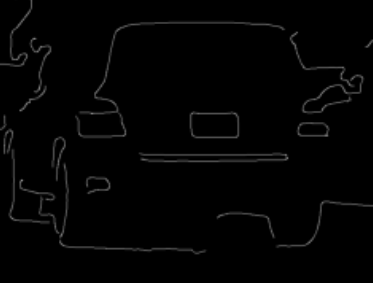 | 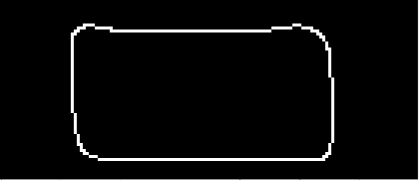|
</div>

In [ ]:
# NE PAS EXEC - Sélectionner des coordonnées
# matplotlib.use('TkAgg')
# plt.imshow(image_canny, cmap='gray')
# coords = np.array(plt.ginput(2))
# print(coords.astype("int"))

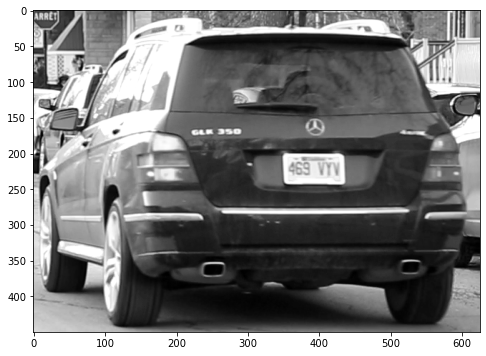

In [39]:
# Crop image
image_crop = image[200:650, 725:1350]
plt.figure(figsize=(8,8))
plt.imshow(image_crop, cmap="gray")

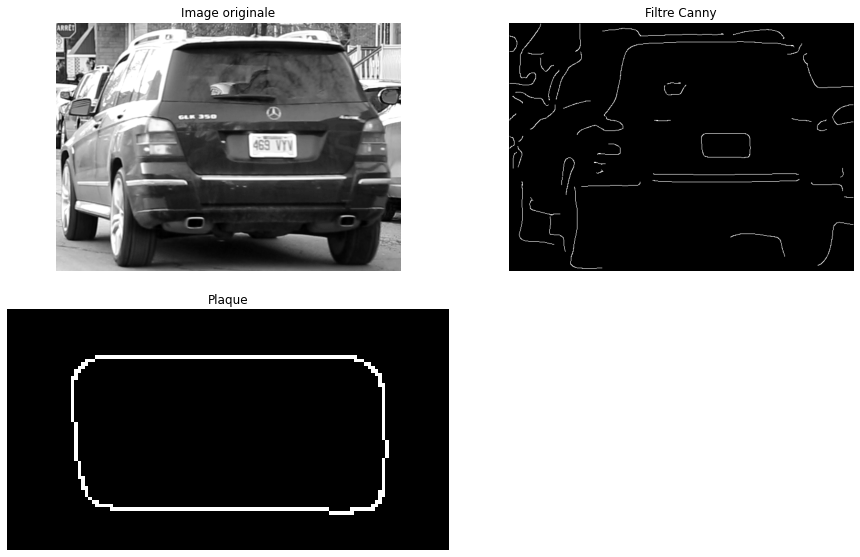

In [40]:
%matplotlib inline

# Filtre Canny
image_canny = canny(image_crop, sigma=6, low_threshold=0.15, high_threshold=None)

# Câdrage plaque
image_plaque_canny = image_canny[187:255, 330:455]

fig, axs = plt.subplots(2,2, figsize=(13,8))
axs[0,0].set_title("Image originale")
axs[0,0].imshow(image_crop, cmap="gray")
axs[0,1].set_title("Filtre Canny")
axs[0,1].imshow(image_canny, cmap="gray")
axs[1,0].set_title("Plaque")
axs[1,0].imshow(image_plaque_canny, cmap="gray")
plt.delaxes(axs[1,1])
plt.tight_layout()
for ax in axs:
    ax[0].axis('off')
    ax[1].axis('off')

<div class="alert alert-block alert-success"> 
Le filtre canny fonctionne en 5 étapes. 1. On applique un filtre gaussien (passe-bas) pour réduire le bruit. 2. On trouve l'intensité et la direction des gradients en x et en y. 3. On affine les contours. Pour chaque pixel, si le pixel voisin selon la direction du gradient (perpendiculaire au contour) a une intensité plus élevée, on assigne la valeur 0 au pixel, car il ne fait qu'élargir le contour. 4. Double seuillage. On définit 2 seuils. Les pixels au dessus du seuil fort sont considérés forts et font très probablement partie d'un contour. Les pixels en dessous du seuil faible ne font pas partie d'un contour et sont supprimés. Les pixels entre les 2 seuils sont entre les 2 classes de pixels et sont considérés faibles. 5. Hystérésis. On analyse le voisinage de chaque pixel faible. Si un pixel fort est présent, le pixel est transformé en pixel fort. Autrement, il est supprimé.
</div>

## 2.2. Transformée de Hough (2 pts) 

<div class="alert alert-block alert-warning">
Afin d’extraire les lignes du contour de la plaque, effectuez la transformée de Hough du “Cadrage de la plaque” que vous avez obtenu. Pour se faire, utilisez la fonction [*hough_line* de scikit-image](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line).

- Expliquez brièvement le fonctionnement de la transformée de Hough (1 pt)

- Présentez la transformée obtenue avec les bons axes (1 pt) 
</div>

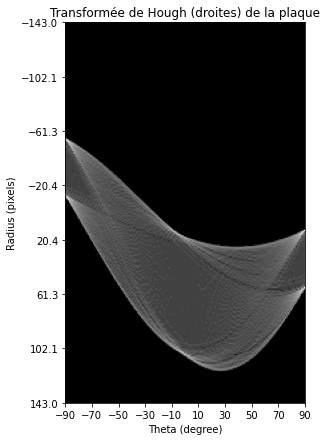

In [42]:
hspace, angles, distances = hough_line(image_plaque_canny)

angles_deg = angles * 360/(2*np.pi)
yticks = np.linspace(distances.min(), distances.max(), 8)
xticks = np.linspace(angles_deg.min(), angles_deg.max(), 10)

extent = [angles_deg.min(), angles_deg.max(), distances.max(), distances.min()]

plt.figure(figsize=(7,7))
ax = plt.gca()
ax.imshow(np.log(1+hspace), cmap="gray", extent=extent, aspect=1)
ax.set_title("Transformée de Hough (droites) de la plaque")
ax.set_ylabel("Radius (pixels)")
ax.set_yticks(yticks)
ax.set_xlabel("Theta (degree)")
ax.set_xticks(xticks)

<div class="alert alert-block alert-success"> 
La transformée de Hough permet de détecter des courbes (ligne, cercle, ellipse, etc.) de contour dans une image. Elle permet de passer d'un espace de points à un espace paramétrique d'une courbe. Pour chaque point de l'image initiale, toutes les courbes (de paramètres p1, p2 , ..., pn) passant par le point sont représentées par un ensemble de points dans l'espace paramétrique aux paramètres correspondants. On trouve les courbes correspondant aux contours en prenant les points (ou régions) dans l'espace de Hough ayant les plus fortes intensités. Dans ce cas-ci, on utilise rho et theta comme paramètres de courbe pour une droite.
</div>



## 2.3. Détection de Rectangle (5 pts) 

On souhaite trouver l’équation des droites correspondantes au contour de la plaque. La figure suivante montre une transformée de Hough caractéristique d’un rectangle. Les points rouges de la **figure 6** correspondent aux maximums de la transformée et ils correspondent aux  droites  du  rectangle.  Il  est  possible  d’ignorer  les  deux  points  de  gauche (ou de droite)  puisqu’ils correspondent à la réflexion des points de droite (-90 degrés équivalent à +90 degrés de rotation).

| <center> Figure 5: Rectangle </center> | <center> Figure 6: Transformée de Hough d'un rectangle </center> |
|------|------|
|   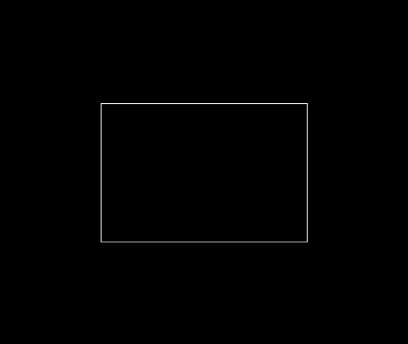 | 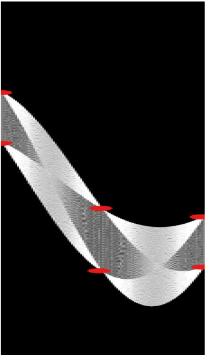|



### 2.3.1 Détection des maximums (2 pts)

<div class="alert alert-block alert-warning">
Détecter les maximums de votre transformée de Hough qui correspondent aux droites du rectangle  grâce à la fonction [*hough_line_peaks* de scikit-image](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line_peaks).  Utilisez les paramètres `num_peaks`, `threshold` et `min_distance` pour isoler les maximums. Présentez  les  coordonnées des droites sous  forme  de  tableau  tel  que  présenté  ci-bas  ou directement sur une figure tel que la **figure 8**.

<br/><br/>

#### <center> Tableau 1: Coordonnées de la transformée de Hough </center>
    
|Coordonnées $\theta$|Coordonnées $\rho$|
|------|------|
|      |      |
|      |      |

</div>

In [44]:
hspace_pt, angles_pt, dists_pt = hough_line_peaks(hspace, angles, distances, num_peaks=4, threshold=0.5, min_distance=10)

print("Tableau 1: coordonnées de la transformée de Hough\n")
print("Coordonnées \u03B8 Coordonnées \u03C1")
print("-----------------------------")
for angle, dist in zip(angles_pt, dists_pt):
    print(f"{angle*360/(2*np.pi):9.2f} {dist:13.2f}")

Tableau 1: coordonnées de la transformée de Hough

Coordonnées θ Coordonnées ρ
-----------------------------
    90.00         13.55
    90.00         56.70
     0.50        106.87
    -4.53         16.56



### 2.3.2 Passage des coordonnées de Hough vers le domaine spatial (3 pts) 

<div class="alert alert-block alert-warning">
Finalement,  extraire  les  coordonnées  spatiales  à  partir  des  coordonnées  de  Hough. L’équation de Hough est :

<br/><br/>

\begin{equation}
    \rho=xcos(\theta)+ysin(\theta)
\end{equation}


<br/><br/>

Trouvez l’intersection de ces droites qui correspond aux quatre coins de la plaque. Obtenez ces  coordonnées  et  appliquez  un  masque  binaire  sur  l’image  originale cadrée sur la plaque afin  d’obtenir seulement la plaque avec la fonction *mask_img*.
    
| <center> Figure 9: Voiture cadrée </center> |
|------|
| 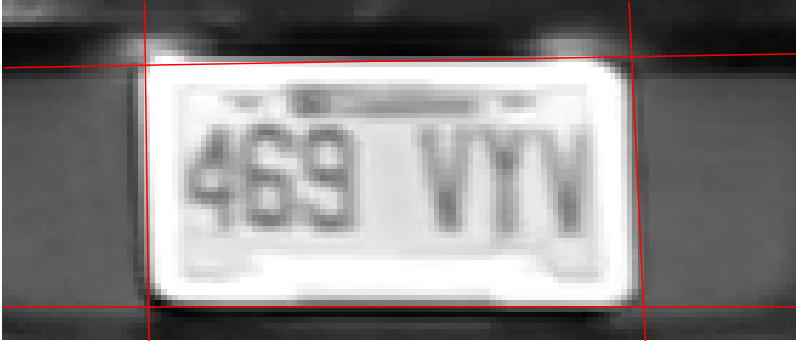 |
</div>

In [45]:
def mask_img(img, y_coords, x_coords):
    """Masquer une image à l'extérieur des coordonnées y_coords et x_coords
    img (ndarray): Image à masquer.
    y_coords (list ou tuple): Liste des coordonnées en y de tous les points.
    x_coord (list ou tuple): Liste des coordonnées en x de tous les points.
    """
    y_coords, x_coords = draw.polygon(y_coords, x_coords, img.shape)
    mask = np.zeros(img.shape, dtype=np.bool)
    mask[y_coords, x_coords] = True
    return convex_hull_image(mask) * img

<ipython-input-46-5d4bec91ee89>:16: RuntimeWarning: divide by zero encountered in double_scalars
  x = (b1-b2)/(a2-a1)


(-0.5, 124.5, 67.5, -0.5)

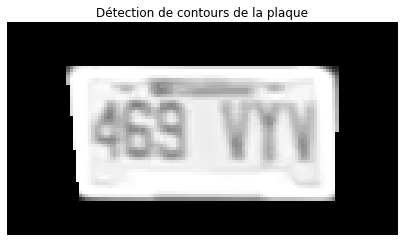

In [46]:
image_crop = image[200:650, 725:1350]
image_plaque = image_crop[187:255, 330:455]

# Calcule les paramètres a et b des droites
a = -np.cos(angles_pt)/np.sin(angles_pt)
b = dists_pt * 1/np.sin(angles_pt)
    
# Trouve les points d'intersections entre chaque droite. 
# Ne conserve que les 4 points d'intérêt
nb_lines = 4
xcoords, ycoords = [], []
for i in range(nb_lines-1):
    for j in range(i+1, nb_lines):
        a1, b1 = a[i], b[i]
        a2, b2 = a[j], b[j]
        x = (b1-b2)/(a2-a1)
        y = a1*x + b1
        if (y <= image_plaque.shape[0] and x <= image_plaque.shape[1]):
            xcoords.append(x)
            ycoords.append(y)
        
image_plaque_hough = mask_img(image_plaque, ycoords, xcoords)
plt.figure(figsize=(7,7))
ax = plt.gca()
ax.imshow(image_plaque_hough, cmap="gray")
ax.set_title("Détection de contours de la plaque")
ax.axis("off")